In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [96]:
df = pd.read_csv('Data/df_transformed.csv')

In [97]:
df = df.drop(columns='ID')

c:\Users\huyho\anaconda3\envs\python-jupyter\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\huyho\anaconda3\envs\python-jupyter\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\huyho\anaconda3\envs\python-jupyter\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Distribution of Non-Defaulter vs Defaulter')

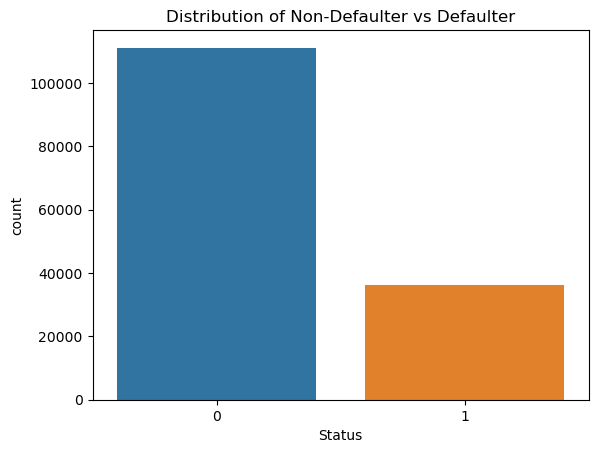

In [98]:
sns.countplot(data=df, x='Status')
plt.title('Distribution of Non-Defaulter vs Defaulter')

# Splitting the Data
We need to splitting the data to get the original testing set before sampling
The main goal is to fit the model either with the dataframes that were sample or the original testing set.

In [99]:
train_set, test_set = train_test_split(df, test_size=0.1, random_state=1, stratify=Target)

# SMOTE
The advantage of SMOTE is it synthesizes new examples from the minority class, as a type of data augmentation for tabular data

In [100]:
from imblearn.over_sampling import SMOTE

In [101]:
train_set['Status'].value_counts()

Status
0    100058
1     32525
Name: count, dtype: int64

In [102]:
sm = SMOTE(random_state=1)
X = train_set.drop(columns='Status')
y = train_set['Status']
X_res, y_res = sm.fit_resample(X, y)

In [103]:
from collections import Counter
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 100058, 1: 100058})


In [104]:
x_train = X_res
y_train = y_res
x_test = test_set.drop(columns='Status')
y_test = test_set['Status']

# Training Model

In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score,recall_score,accuracy_score,roc_auc_score,roc_curve
from sklearn.metrics import confusion_matrix,auc,r2_score,f1_score,confusion_matrix,roc_curve,precision_recall_curve

In [106]:
#Logistic Regression and CART
lr= LogisticRegression()
dt= DecisionTreeClassifier(max_depth=10)
classifiers=[('Logistic Regression',lr),('CART',dt)]

for clf_name, clf in classifiers:
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(f'{clf_name} for test set: {accuracy_score(y_test,y_pred)}')
    print(f'Train Accuracy: {clf.score(x_train, y_train)}')

c:\Users\huyho\anaconda3\envs\python-jupyter\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression for test set: 0.5077382568558241
Train Accuracy: 0.5639079333986288
CART for test set: 1.0
Train Accuracy: 1.0


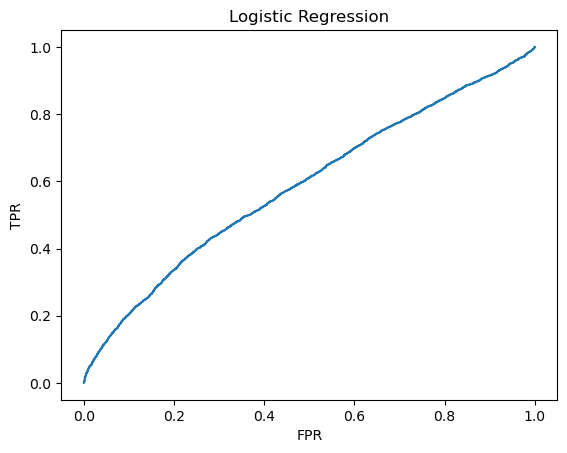

AUC SCORE:0.5886125671259248
F1 Score: 0.39048579593208943


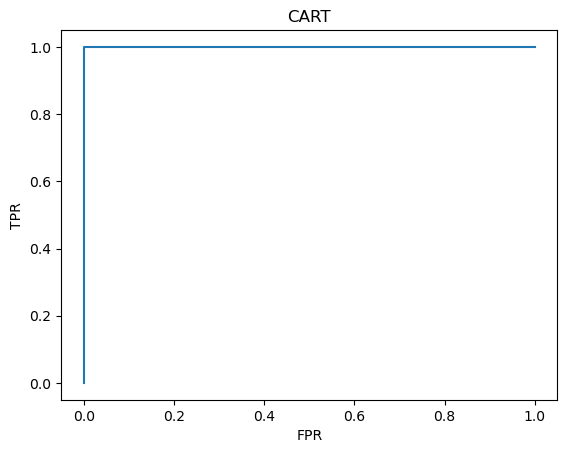

AUC SCORE:1.0
F1 Score: 1.0


In [107]:
for clf_name,clf in classifiers:
    y_pred = clf.predict(x_test)
    y_pred_proba=clf.predict_proba(x_test)[:,1]
    fpr,tpr,thresholds=roc_curve(y_test,y_pred_proba)
    plt.plot(fpr,tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(clf_name)
    plt.show()
    print(f'AUC SCORE:{roc_auc_score(y_test,y_pred_proba)}')
    print(f'F1 Score: {f1_score(y_test, y_pred)}')

# Bagging

In [108]:
from sklearn.ensemble import BaggingClassifier
dt=DecisionTreeClassifier(max_depth=10,min_samples_leaf=16)
bc=BaggingClassifier(estimator=dt,n_estimators=300,n_jobs=-1)
bc.fit(x_train,y_train)
y_pred=bc.predict(x_test)
print(accuracy_score(y_test,y_pred))

1.0


# AdaBoostClassifier

In [109]:
from sklearn.ensemble import AdaBoostClassifier
ad=AdaBoostClassifier(estimator=dt,n_estimators=1)
ad.fit(x_train,y_train)
y_pred=ad.predict(x_test)
print(accuracy_score(y_test,y_pred))

c:\Users\huyho\anaconda3\envs\python-jupyter\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


1.0


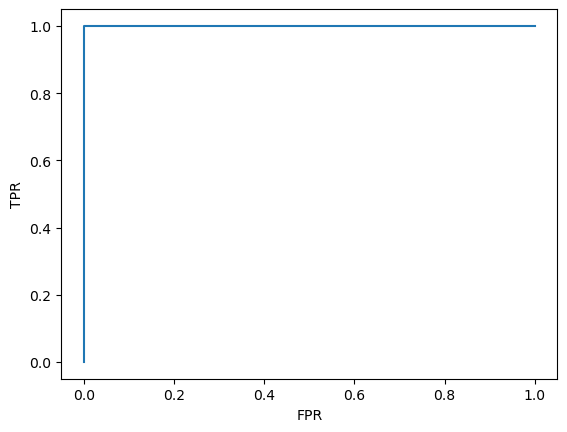

In [110]:
from sklearn.metrics import roc_curve
y_pred_proba=ad.predict_proba(x_test)[:,1]
fpr,tpr,thresholds=roc_curve(y_test,y_pred_proba)
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

# Deep Learning

In [112]:
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
#from keras.utils import to_categorical
#from keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras import callbacks
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 31, kernel_initializer = 'uniform', activation = 'relu', input_dim = 31))
model.add(Dense(units = 31, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(x_train, y_train, batch_size = 32, epochs = 50 , validation_split=0.2)

Epoch 1/50


c:\Users\huyho\anaconda3\envs\python-jupyter\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5003/5003 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7490 - loss: 0.4905 - val_accuracy: 1.0000 - val_loss: 0.0672
Epoch 2/50
5003/5003 ━━━━━━━━━━━━━━━━━━━━ 5s 975us/step - accuracy: 0.9785 - loss: 0.0894 - val_accuracy: 1.0000 - val_loss: 0.0064
Epoch 3/50
5003/5003 ━━━━━━━━━━━━━━━━━━━━ 5s 910us/step - accuracy: 0.9800 - loss: 0.0677 - val_accuracy: 0.9999 - val_loss: 0.0019
Epoch 4/50
5003/5003 ━━━━━━━━━━━━━━━━━━━━ 5s 926us/step - accuracy: 0.9797 - loss: 0.0605 - val_accuracy: 1.0000 - val_loss: 4.7617e-04
Epoch 5/50
5003/5003 ━━━━━━━━━━━━━━━━━━━━ 5s 936us/step - accuracy: 0.9800 - loss: 0.0564 - val_accuracy: 1.0000 - val_loss: 1.9730e-04
Epoch 6/50
5003/5003 ━━━━━━━━━━━━━━━━━━━━ 5s 923us/step - accuracy: 0.9801 - loss: 0.0538 - val_accuracy: 1.0000 - val_loss: 9.8871e-05
Epoch 7/50
5003/5003 ━━━━━━━━━━━━━━━━━━━━ 5s 901us/step - accuracy: 0.9809 - loss: 0.0523 - val_accuracy: 1.0000 - val_loss: 5.2388e-05
Epoch 8/50
5003/5003 ━━━━━━━━━━━━━━━━━━━━ 5s 906us/step - accuracy: 0.979

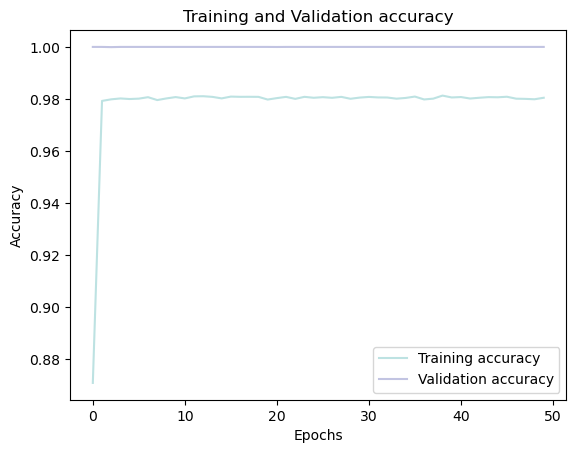

In [113]:
#Plotting training and validation accuracy over epochs

history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [114]:
# Predicting the test set results
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5)

461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step


<Axes: >

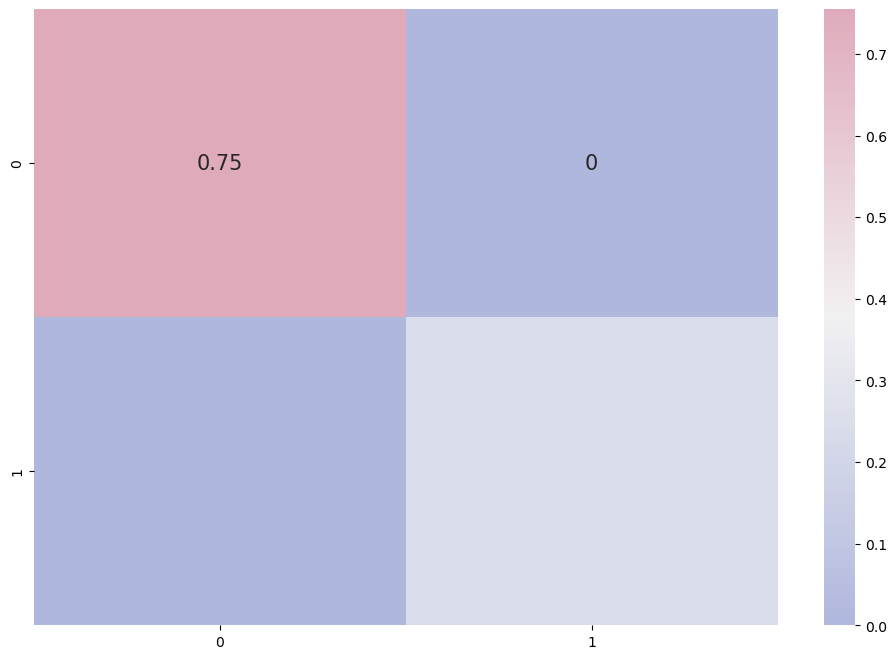

In [119]:
# confusion matrix
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [117]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11118
           1       1.00      1.00      1.00      3614

    accuracy                           1.00     14732
   macro avg       1.00      1.00      1.00     14732
weighted avg       1.00      1.00      1.00     14732



In [118]:
print(accuracy_score(y_test,y_pred))

0.9999321205538962
